# GPT from Scratch: A Complete Implementation

## Overview
This notebook provides a comprehensive implementation of a Generative Pre-trained Transformer (GPT) model built entirely from scratch using PyTorch. The implementation demonstrates the core concepts of modern language models, including multi-head attention mechanisms, transformer blocks, and autoregressive text generation.

## Architecture Highlights
- **Custom Tokenizer**: Simple regex-based tokenization with special tokens handling
- **Masked Multi-Head Attention**: Causal attention mechanism preventing future token access
- **Transformer Blocks**: Complete implementation with layer normalization and residual connections
- **Position Encoding**: Learnable positional embeddings for sequence understanding
- **Temperature Sampling**: Configurable text generation with multinomial sampling

## Model Specifications
| Parameter | Value |
|-----------|-------|
| Context Size | 20 tokens |
| Vector Dimension | 300 |
| Number of Heads | 15 |
| Number of Layers | 15 |
| Vocabulary Size | 39,070 tokens |
| Total Parameters | ~39.7M |
| Model Size | ~151.57 MB |

## Dataset
- **Source**: The Complete Works of William Shakespeare from Project Gutenberg
- **Training Split**: 90% for training, 10% for validation
- **Preprocessing**: Tokenization with special tokens (`<UNK>`, `<BOS>`, `<EOS>`, `<PAD>`)

## Implementation Features
1. **Data Pipeline**: Custom data loader with configurable batch size and stride
2. **Attention Mechanism**: Scaled dot-product attention with causal masking
3. **Training Loop**: Complete training pipeline with gradient clipping and validation
4. **Text Generation**: Temperature-controlled sampling for creative text generation
5. **Custom Loss Function**: Implementation of cross-entropy loss from scratch

## Key Components
- `SmallTokenizer`: Handles text tokenization and encoding/decoding
- `MaskedMultiHeadAttention`: Core attention mechanism with causal masking
- `TransformerBlock`: Complete transformer layer with normalization and feedforward
- `GPT`: Main model class combining all components
- `generate_text`: Text generation function with temperature scaling

## Training Results
The model was trained for 20 epochs on Shakespeare's complete works, showing consistent improvement in training loss while maintaining generalization capability. The final model demonstrates coherent text generation in Shakespearean style.

# Load dependencies

In [ ]:
import requests
import re
import torch
import torch.nn as nn
import torch.nn.functional as F

In [ ]:
cfg = {
    "context_size": 20,
    "vector_dimension": 300,
    "batch_size": 32,
    "stride": 5,
    "n_heads": 15,
    "n_layer": 15,
    "drop_rate": 0.1,
    "learning_rate": 5e-5
}

# 1. Data Preparation

## 1.1. Load the data

In [ ]:
# URL of the plain text file of dataset: The Complete Works of William Shakespeare
url = "https://www.gutenberg.org/cache/epub/100/pg100.txt"

In [ ]:
response = requests.get(url)
text = response.text
text = text.lstrip('\ufeff')   # This will remove the Byte Order Mark (BOM) as "\ufeff"

print("The number of characters:",len(text))
print(text[:500])

The number of characters: 5575052
The Project Gutenberg eBook of The Complete Works of William Shakespeare
    
This ebook is for the use of anyone anywhere in the United States and
most other parts of the world at no cost and with almost no restrictions
whatsoever. You may copy it, give it away or re-use it under the terms
of the Project Gutenberg License included with this ebook or online
at www.gutenberg.org. If you are not located in the United States,
you will have to check the laws of the country where you are locat


## 1.2. Tokenize the data

In [ ]:
class SmallTokenizer:
  def __init__(self, text):

    tokens = self.__tokenize(text)
    all_words = sorted(set(tokens))

    # Adding Special Tokens
    # - <UNK> -> Handling out-of-vocabulary words
    # - (BOS) -> Put in begenning of each document
    # - (EOS) -> Put in end of each document
    # - Padding (BAD) -> Handling unequal sentences in length
    all_words.extend(('<UNK>','<BOS>','<EOS>','<PAD>'))

    self.voc_str_int = {word: i for i, word in enumerate(all_words)}
    self.voc_int_str = {i: word for i, word in enumerate(all_words)}

  def __tokenize(self, text):

    tokens = re.split(r'([,.?_!"()\':;]|--|\s)', text)

    tokens = [token.strip() for token in tokens if token.strip()]

    return tokens

  def encode(self, text):

    tokens = self.__tokenize(text)

    ids = [self.voc_str_int.get(token, self.voc_str_int['<UNK>']) for token in tokens]

    return ids

  def decode(self, ids):

    tokens = [self.voc_int_str.get(id, '<UNK>') for id in ids]

    text = ' '.join(tokens)

    text = re.sub(r'\s+([,.?_!"()\':;]|--|\s)', r'\1', text) # Remove spaces before this specified characters (eg. ,.?)

    return text

  def __len__(self):
    return len(self.voc_str_int)


## 1.3. Data Loader

In [ ]:
class SmallDataLoader:
  def __init__(self, token_ids, context_size=4, batch_size=4, stride=1):
    self.context_size = context_size
    self.batch_size = batch_size
    self.stride = stride

    self.X, self.Y = self.__create_dataset(token_ids)

  def __create_dataset(self, token_ids):
    X, Y = [], []
    for i in range(0, len(token_ids) - self.context_size - 1, self.stride):
      x = token_ids[i : i + self.context_size]
      y = token_ids[i + 1 : i + self.context_size + 1]

      if len(y) == self.context_size:
        X.append(x)
        Y.append(y)

    return torch.tensor(X, dtype=torch.long), torch.tensor(Y, dtype=torch.long)

  def __len__(self):
    return len(self.X) // self.batch_size

  def __getitem__(self, idx):
    if idx >= len(self):
          raise IndexError("Batch index out of range")
    start = idx * self.batch_size
    end = start + self.batch_size
    return self.X[start:end], self.Y[start:end]


## 1.4. Tokenize text and create data loaders

In [ ]:
# Create Tokenizer
tokenizer = SmallTokenizer(text)
token_ids = tokenizer.encode(text)
cfg['vocabulary_size'] = len(tokenizer)

# Split (90% training, 10% validation)
split_ratio = 0.9
split_index = int(len(token_ids) * split_ratio)
train_token_ids = token_ids[:split_index]
val_token_ids = token_ids[split_index:]

# Create Data Loader
train_dataloader = SmallDataLoader(train_token_ids, cfg["context_size"], cfg["batch_size"], cfg["stride"])
val_dataloader = SmallDataLoader(val_token_ids, cfg["context_size"], cfg["batch_size"], cfg["stride"])
x_batch, y_batch = train_dataloader[0]

print("Vocabulary size:", len(tokenizer))
print("Number of training batchs:", len(train_dataloader))
print("Number of validation batchs:", len(val_dataloader))

print("X text", tokenizer.decode(x_batch[0].tolist()))
print("X ids:", x_batch[0])
print("Y text", tokenizer.decode(y_batch[0].tolist()))
print("Y ids:", y_batch[0])

Vocabulary size: 39070
Number of training batchs: 6799
Number of validation batchs: 755
X text The Project Gutenberg eBook of The Complete Works of William Shakespeare This ebook is for the use of anyone anywhere
X ids: tensor([ 9091,  7281,  4357, 17649, 26245,  9091,  2268, 10198, 26245, 10104,
         8234,  9147, 17746, 22852, 19606, 33958, 35965, 26245, 11229, 11233])
Y text Project Gutenberg eBook of The Complete Works of William Shakespeare This ebook is for the use of anyone anywhere in
Y ids: tensor([ 7281,  4357, 17649, 26245,  9091,  2268, 10198, 26245, 10104,  8234,
         9147, 17746, 22852, 19606, 33958, 35965, 26245, 11229, 11233, 22311])


# 2. Masked multi-head attention by weights splits with query, key, and value matrices

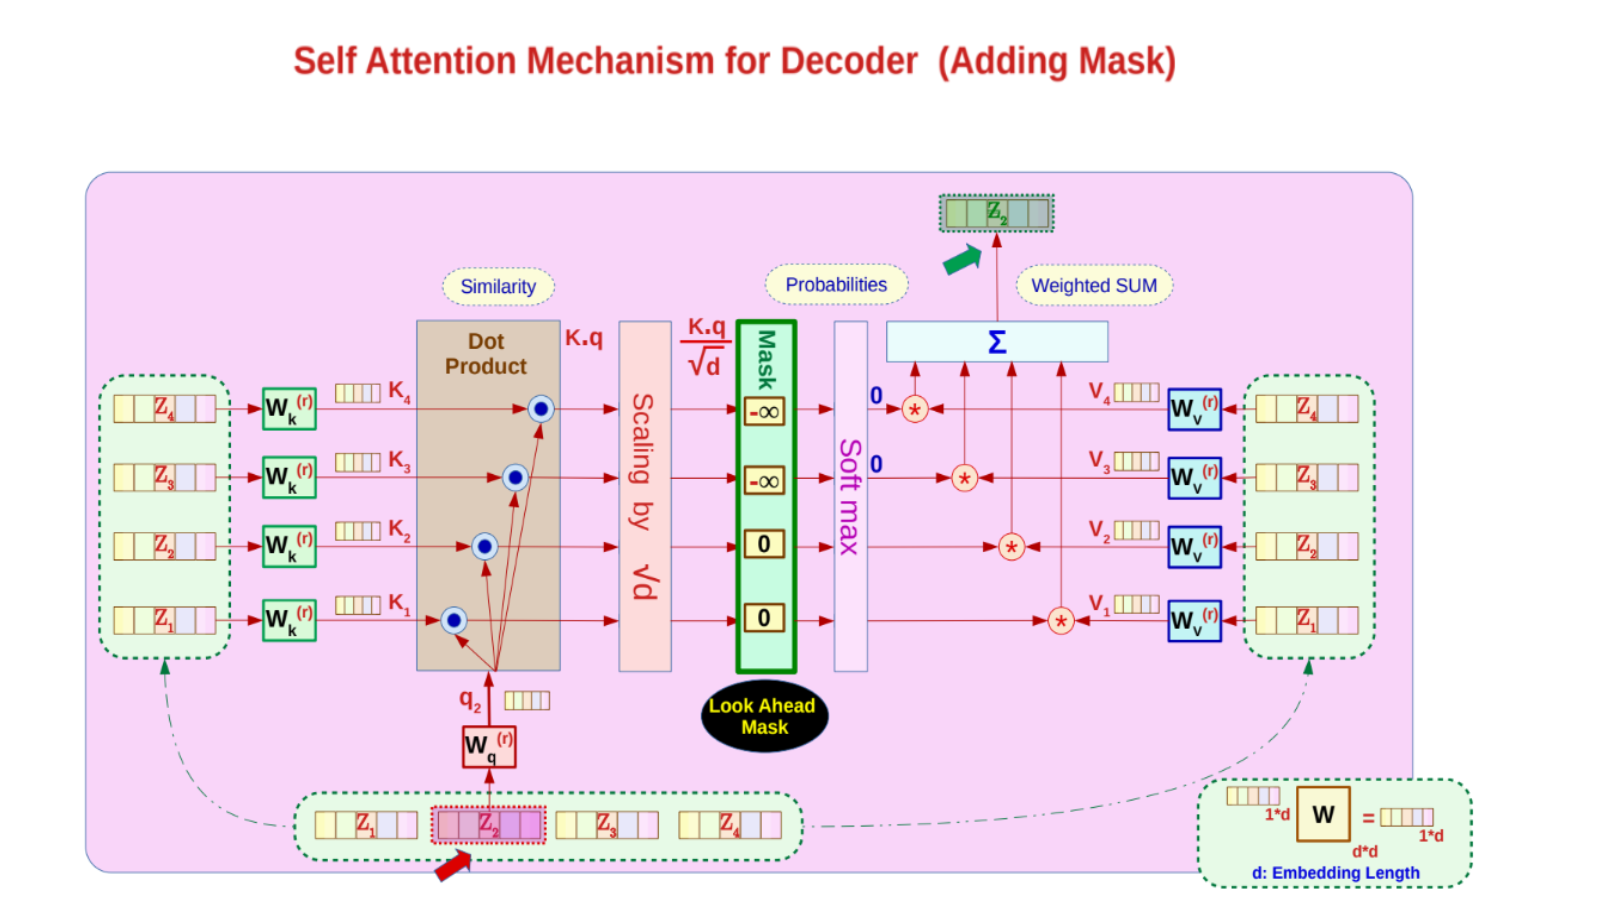

In [ ]:
class MaskedMultiHeadAttention(nn.Module):
    def __init__(self, vector_dim, output_dim, num_heads):
        super(MaskedMultiHeadAttention, self).__init__()

        self.vector_dim = vector_dim    # Dimension of input embeddings
        self.output_dim = output_dim    # Dimension of Q, K, V, and final output
        self.num_heads = num_heads
        self.head_dim = output_dim // num_heads  # Dimension per head

        # Linear projections
        self.query = nn.Linear(vector_dim, output_dim, bias=False)
        self.key   = nn.Linear(vector_dim, output_dim, bias=False)
        self.value = nn.Linear(vector_dim, output_dim, bias=False)

        # Final output projection
        self.out_proj = nn.Linear(output_dim, output_dim)

        # Causal mask: upper-triangular matrix filled with -inf (except diagonal and below)
        self.register_buffer("causal_mask", torch.tril(torch.ones(1000, 1000)).unsqueeze(0).unsqueeze(0))  # (1, 1, max_context, max_context)

    def forward(self, x):
        Batch, context_size, _ = x.shape  # (Batch, context_size, vector_dim)

        # Linear projections: (Batch, context_size, vector_dim) * (vector_dim, output_dim) = (Batch, context_size, output_dim)
        Queries = self.query(x)
        Keys    = self.key(x)
        Values  = self.value(x)

        # Reshape: (Batch, context_size, output_dim) → (Batch, context_size, num_heads, head_dim)
        Queries = Queries.view(Batch, context_size, self.num_heads, self.head_dim)
        Keys    = Keys.view(Batch, context_size, self.num_heads, self.head_dim)
        Values  = Values.view(Batch, context_size, self.num_heads, self.head_dim)

        # Transpose to (Batch, num_heads, context_size, head_dim)
        Queries = Queries.transpose(1, 2)
        Keys    = Keys.transpose(1, 2)
        Values  = Values.transpose(1, 2)

        # Compute attention scores: (Batch, num_heads, context_size, head_dim) * (Batch, num_heads, head_dim, context_size) = (Batch, num_heads, context_size, context_size)
        AttentionScores = torch.matmul(Queries, Keys.transpose(-2, -1))

        # Apply causal mask: (Batch, num_heads, context_size, context_size)
        mask = self.causal_mask[:, :, :context_size, :context_size]  # crop mask to match context_size
        AttentionScores = AttentionScores.masked_fill(mask == 0, float('-inf'))

        # Scale and apply softmax
        AttentionWeights = F.softmax(AttentionScores / (self.head_dim ** 0.5), dim=-1)

        # Weighted sum: (Batch, num_heads, context_size, context_size) * (Batch, num_heads, context_size, head_dim) = (Batch, num_heads, context_size, head_dim)
        Context = torch.matmul(AttentionWeights, Values)

        # Transpose back: (Batch, context_size, num_heads, head_dim)
        Context = Context.transpose(1, 2)

        # Concatenate heads: (Batch, context_size, num_heads * head_dim) = (Batch, context_size, output_dim)
        Context = Context.contiguous().view(Batch, context_size, self.output_dim)

        # Final output projection
        Output = self.out_proj(Context)  # (Batch, context_size, output_dim)

        return Output


# 3. GPT Block

## 3.1. Layer Normalization

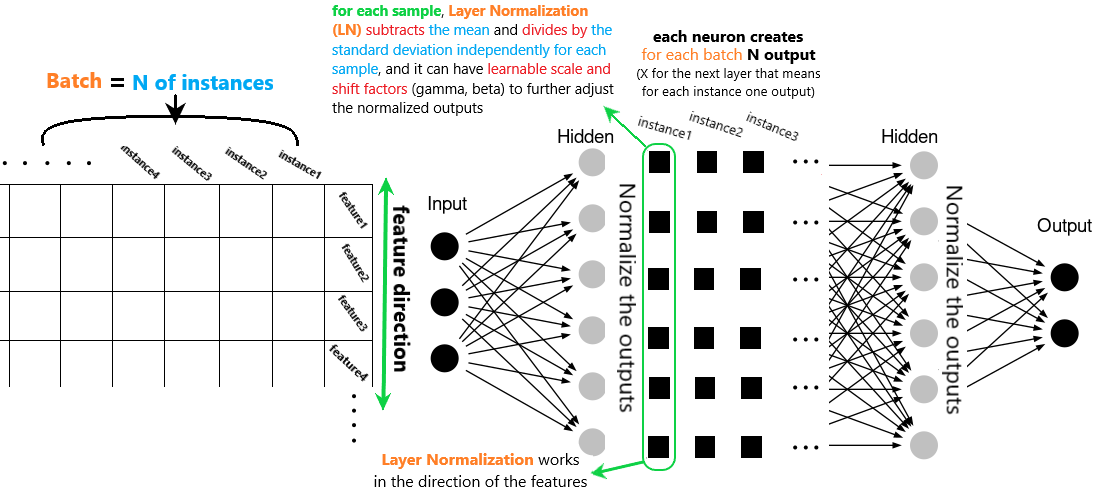

In [ ]:
class LayerNorm(nn.Module):
  def __init__(self, vector_dim):
    super().__init__()
    self.eps = 1e-5
    self.scale = nn.Parameter(torch.ones(vector_dim))
    self.shift = nn.Parameter(torch.zeros(vector_dim))

  def forward(self, x):
    mean = x.mean(dim = -1, keepdim = True)
    std = x.std(dim=-1, keepdim=True, unbiased=False)
    norm_x = (x - mean) / (std + self.eps)

    return self.scale * norm_x + self.shift # This allows the model to learn appropriate scaling and shifting that best suit the data

## 3.2. Gelu activation function

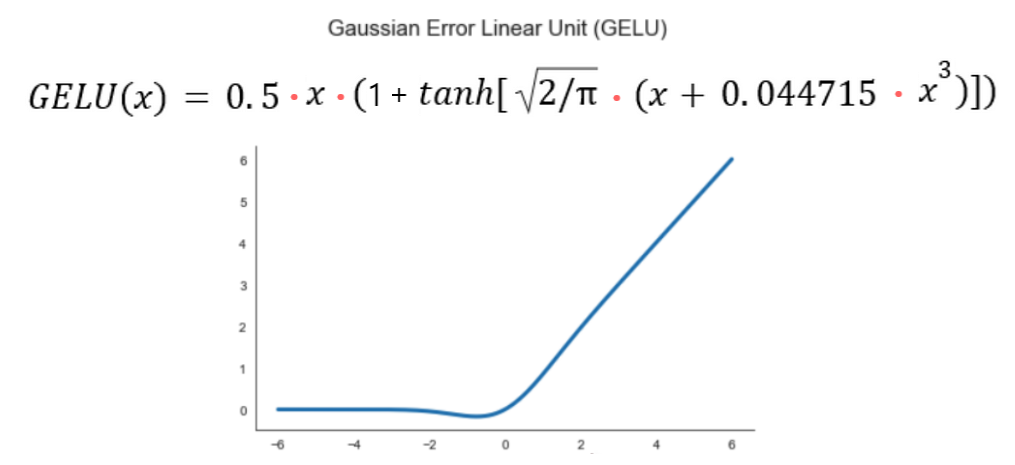

In [ ]:
class Gelu(nn.Module):
  def __init__(self):
    super().__init__()

  def forward(self, x):
    return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2 / torch.pi)) *
             (x + 0.044715 * torch.pow(x, 3))
             )
          )

## 3.3. Feedforward network

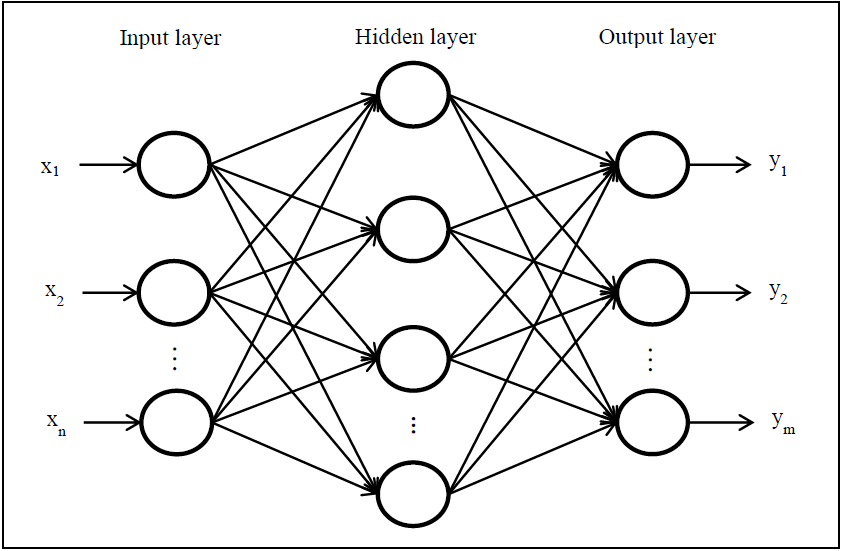

In [ ]:
class FeedForward(nn.Module):
  def __init__(self, vector_dim):
    super().__init__()
    self.net = nn.Sequential(
        nn.Linear(vector_dim, 4 * vector_dim),
        Gelu(),
        nn.Linear(4 * vector_dim, vector_dim),
    )

  def forward(self, x):
    return self.net(x)

## 3.4. Transformer architecture

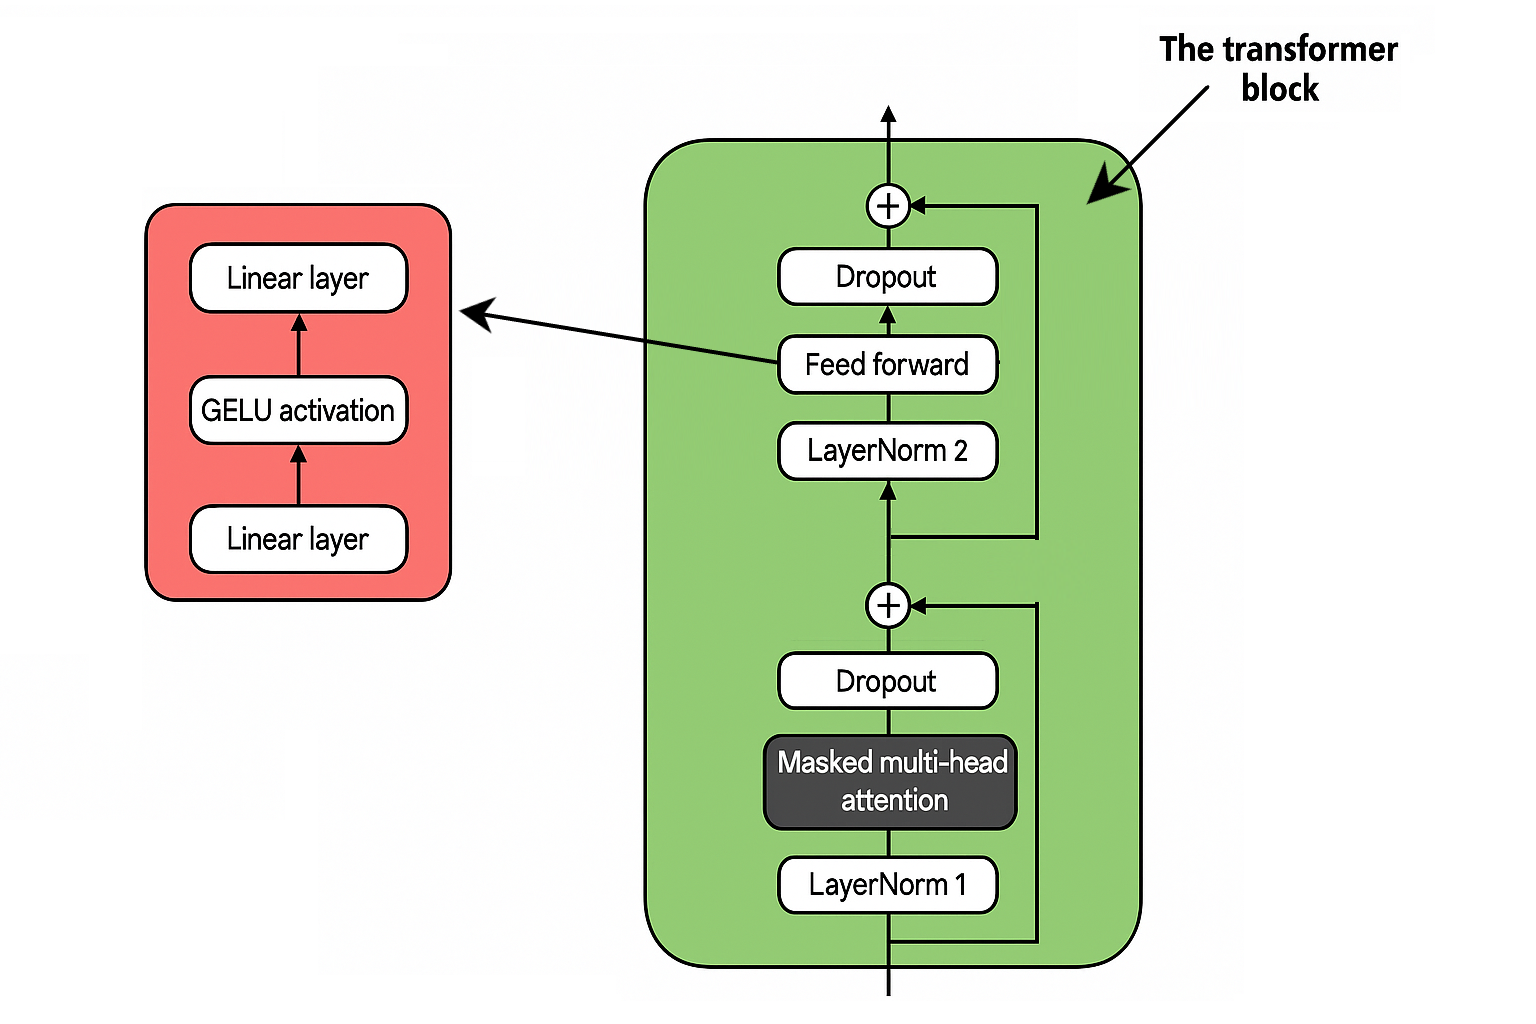

In [ ]:
class TransformerBlock(nn.Module):
  def __init__(self, cfg):
    super(TransformerBlock, self).__init__()

    # Attention block
    self.Normlayer1 = LayerNorm(cfg["vector_dimension"])  # First norm layer
    # Masked multi-head attenstion
    self.multihead_att = MaskedMultiHeadAttention(cfg["vector_dimension"], cfg["vector_dimension"], cfg["n_heads"])
    self.dropout1 = nn.Dropout(cfg["drop_rate"])  # First dropout layer

    # feedforward block
    self.Normlayer2 = LayerNorm(cfg["vector_dimension"])  # Second norm layer
    self.feedforward = FeedForward(cfg["vector_dimension"])  # Feedforward layer
    self.dropout2 = nn.Dropout(cfg["drop_rate"])  # Second dropout layer

  def forward(self, x):  # (batch_size, context_size, vector_dim)

    # Shortcut connection for attention block
    shortcut = x
    x = self.Normlayer1(x)
    x = self.multihead_att(x)
    x = self.dropout1(x)
    x = x + shortcut

    # shortcut connection for feed forward block
    shortcut = x
    x = self.Normlayer2(x)
    x = self.feedforward(x)
    x = self.dropout2(x)
    return x + shortcut   # (batch_size, context_size, vector_dim)

## 3.5. GPT model

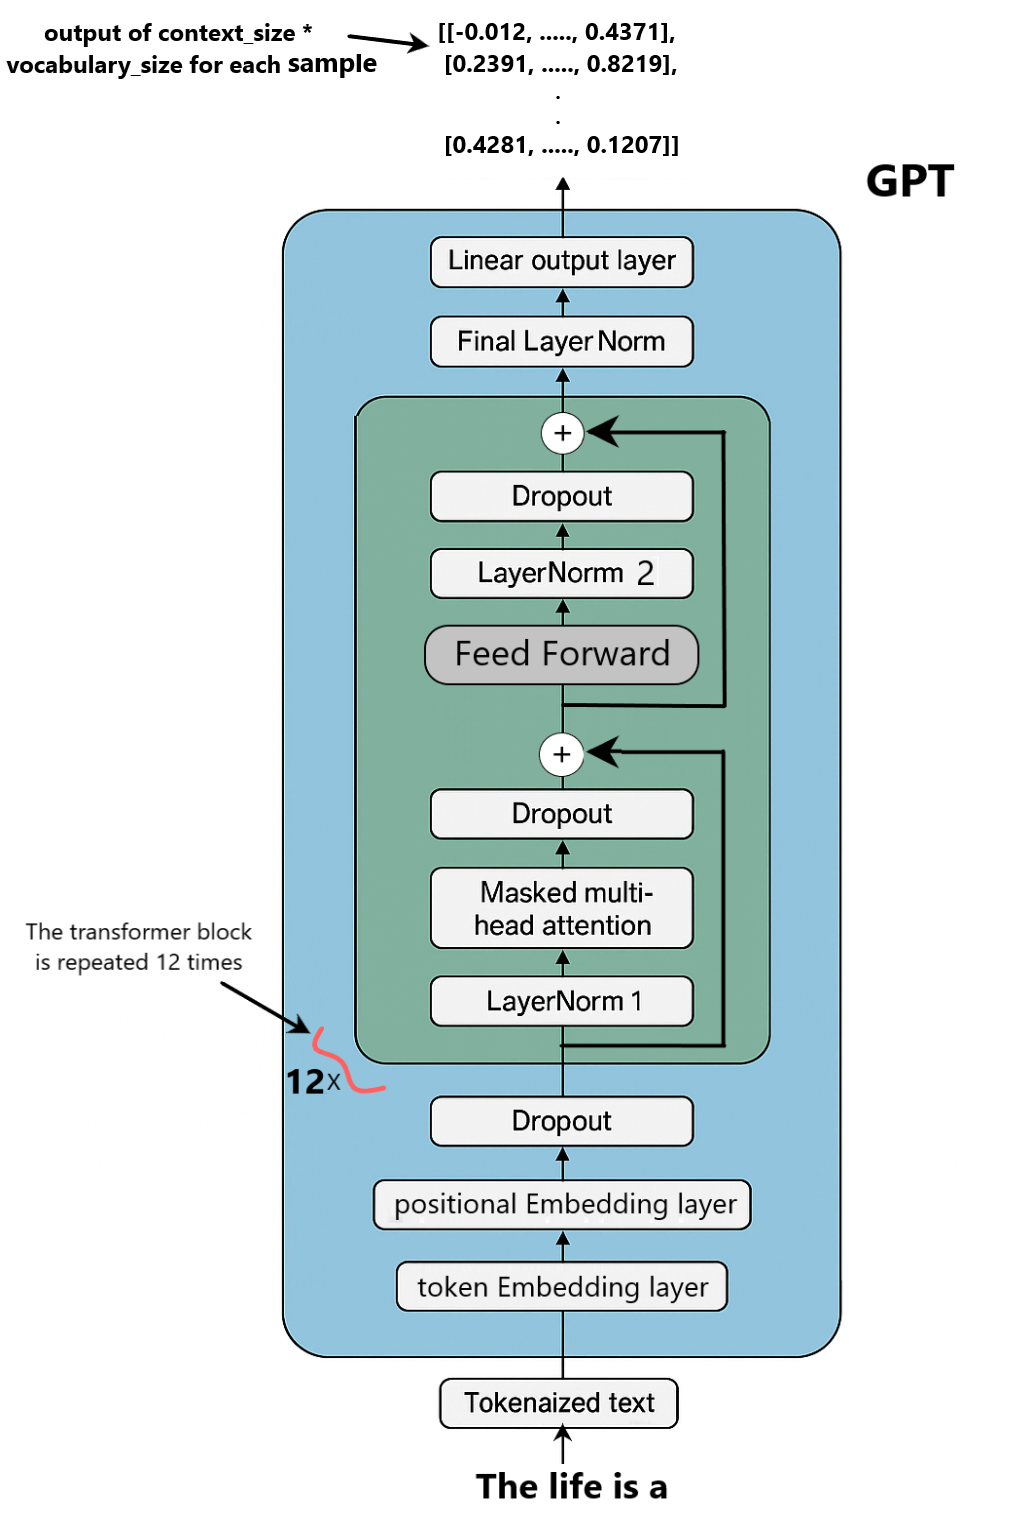

In [ ]:
class GPT(nn.Module):
  def __init__(self, cfg):
    super().__init__()

    self.embedding_layer = nn.Embedding(cfg['vocabulary_size'], cfg["vector_dimension"])  # Embedding layer
    self.position_layer = nn.Embedding(cfg["context_size"], cfg["vector_dimension"])  # Positional Embedding Layer
    self.drop_out = nn.Dropout(cfg["drop_rate"])

    self.transformerblocks = nn.Sequential(
        *[TransformerBlock(cfg) for _ in range(cfg["n_layer"])]  # Use unpacking *[] to pass each module as a separate argument
        )

    self.norm_layer = LayerNorm(cfg["vector_dimension"])
    self.output_layer = nn.Linear(cfg["vector_dimension"], cfg["vocabulary_size"])

  def forward(self, x):
    context_size = x.shape[-1]

    x_embedding = self.embedding_layer(x)  # Get batch Embedding
    x_position = self.position_layer(torch.arange(context_size, device=x.device))  # Generate position indices: shape (context_size,)
    position_encoded_values = x_embedding + x_position  # Add position encoding

    dropped_x = self.drop_out(position_encoded_values)
    x = self.transformerblocks(dropped_x)

    x = self.norm_layer(x)
    logits = self.output_layer(x)

    return logits

In [ ]:
# Create gpt model
gpt_model = GPT(cfg)

# Show number of parameters
num_parameters = sum(p.numel() for p in gpt_model.parameters())
print(f"Number of parameters: {num_parameters:,}")

# Each parameter is usually a 32-bit float (4 bytes)
param_memory_MB = num_parameters * 4 / (1024 ** 2)  # in megabytes
print(f"Model parameter memory: {param_memory_MB:.2f} MB")

Number of parameters: 39,732,670
Model parameter memory: 151.57 MB


# 4. Training GPT model

## 4.1. Cross Entropy Loss

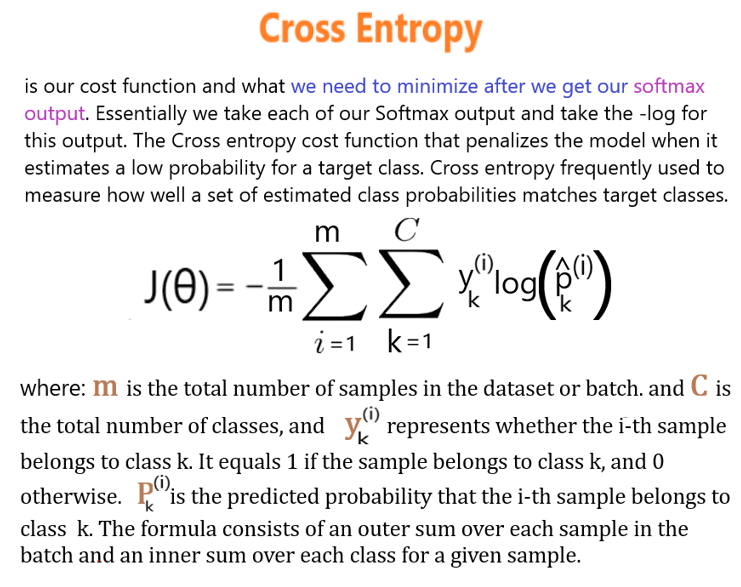

In [ ]:
class MyCrossEntropyLoss(nn.Module):
  def __init__(self):
    super(MyCrossEntropyLoss, self).__init__()

  def forward(self, logits, targets):
    """
    logits: Tensor of shape (N, C) — raw scores from the model
    targets: Tensor of shape (N,) — correct class indices for each example
    """
    # Compute log softmax
    # probs[i][j] = exp(logits[i][j]) / sum_k exp(logits[i][k])
    # log_probs = log(probs[i][j])
    log_probs = F.log_softmax(logits, dim=1)  # shape: (N, C)

    # Select the log-probability of the correct class for each sample
    # target_log_probs[i] = log_probs[i][targets[i]]
    target_log_probs = log_probs[torch.arange(logits.size(0)), targets]  # shape: (N,)

    # Compute the mean negative log-likelihood
    # loss = - (1/N) * sum_i target_log_probs[i]
    loss = -target_log_probs.mean()
    return loss

## 4.2. Training loop

In [ ]:
optimizer = torch.optim.Adam(gpt_model.parameters(), lr=cfg["learning_rate"])
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt_model.to(device)

epochs = 20
criterion = MyCrossEntropyLoss() # Instantiate custom loss

for epoch in range(epochs):
    gpt_model.train()  # Set model to training mode
    total_train_loss = 0

    # Assuming train_dataloader provides batches of (input_ids, target_ids)
    for batch_idx, (inputs, targets) in enumerate(train_dataloader):

        # Adding inputs and targets into the device
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()  # Clear previous gradients

        # Forward pass
        logits = gpt_model(inputs)

        # Reshape logits and targets for the custom loss function
        logits = logits.view(-1, logits.size(-1)) # (batch_size * sequence_length, vocab_size)
        targets = targets.view(-1)              # (batch_size * sequence_length,)

        loss = criterion(logits, targets)

        # Backward pass and optimization
        loss.backward()

        # Add gradient clipping
        torch.nn.utils.clip_grad_norm_(gpt_model.parameters(), max_norm=1.0)

        optimizer.step()

        total_train_loss += loss.item()

    avg_train_loss = total_train_loss / len(train_dataloader)

    # validation loop after each epoch
    gpt_model.eval() # Set model to evaluation mode

    total_val_loss = 0
    with torch.no_grad(): # Disable gradient computation during validation
        for inputs, targets in val_dataloader:
              inputs, targets = inputs.to(device), targets.to(device) # Uncomment if using GPU

              logits = gpt_model(inputs)

              logits = logits.view(-1, logits.size(-1))
              targets = targets.view(-1)

              loss = criterion(logits, targets)
              total_val_loss += loss.item()
    avg_val_loss = total_val_loss / len(val_dataloader)
    print(f'Epoch [{epoch+1}/{epochs}] Training Loss: {avg_train_loss:.4f}   Validation Loss: {avg_val_loss:.4f}')

print("Training finished.")


Epoch [1/20] Training Loss: 6.0518   Validation Loss: 6.2607
Epoch [2/20] Training Loss: 5.3261   Validation Loss: 6.1568
Epoch [3/20] Training Loss: 5.0592   Validation Loss: 6.0885
Epoch [4/20] Training Loss: 4.8783   Validation Loss: 6.0514
Epoch [5/20] Training Loss: 4.7338   Validation Loss: 6.0376
Epoch [6/20] Training Loss: 4.6077   Validation Loss: 6.0429
Epoch [7/20] Training Loss: 4.4917   Validation Loss: 6.0523
Epoch [8/20] Training Loss: 4.3814   Validation Loss: 6.0767
Epoch [9/20] Training Loss: 4.2741   Validation Loss: 6.1028
Epoch [10/20] Training Loss: 4.1673   Validation Loss: 6.1521
Epoch [11/20] Training Loss: 4.0611   Validation Loss: 6.1978
Epoch [12/20] Training Loss: 3.9545   Validation Loss: 6.2518
Epoch [13/20] Training Loss: 3.8474   Validation Loss: 6.3094
Epoch [14/20] Training Loss: 3.7400   Validation Loss: 6.3738
Epoch [15/20] Training Loss: 3.6333   Validation Loss: 6.4330
Epoch [16/20] Training Loss: 3.5265   Validation Loss: 6.4993
Epoch [17/20] Tra

# 5. Generate text using multinomial sampling (Temperature Scaling)


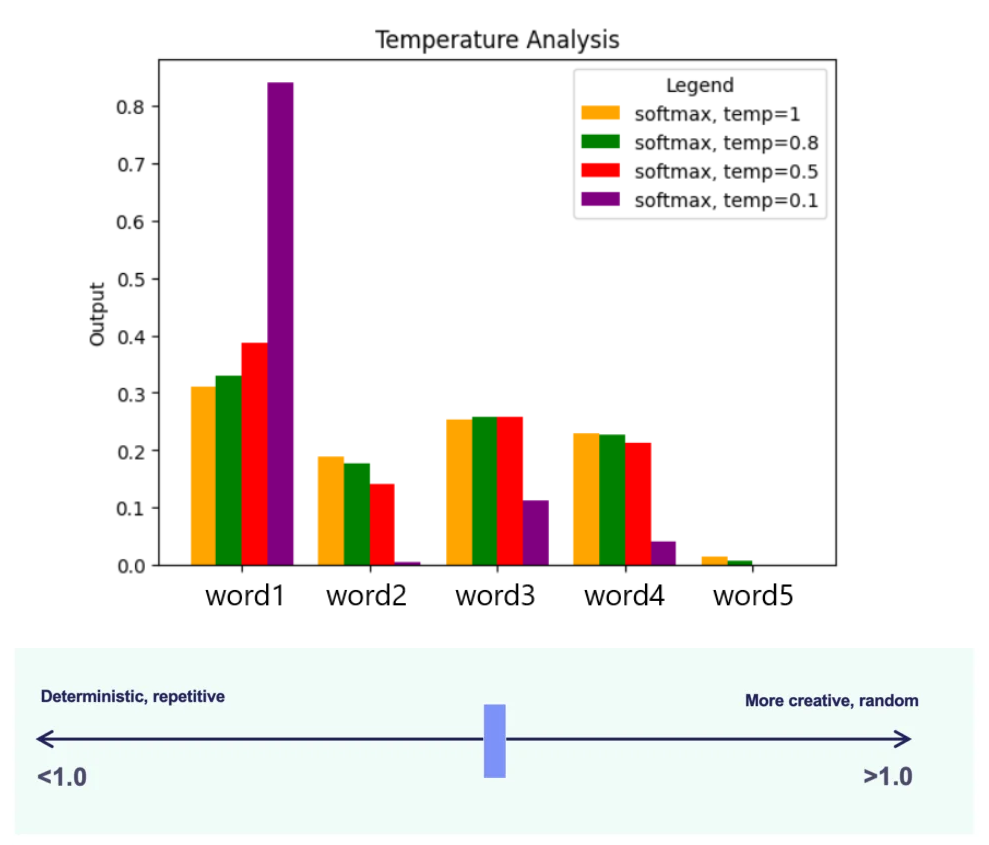

In [ ]:
def generate_text(model, idx, max_tokens, context_size, temperature = 1):

  for _ in range(max_tokens):

    # Take the last context_size tokenx (Batch_size, context_size)
    idx_window = idx[:, -context_size:]

    with torch.no_grad():
      logits = model(idx_window)  # (Batch_size, context_size, vocabulary_size)

    # Take the entire batch with entire vecotr for the last token only (-1) (Batch_size, vocabulary_size)
    logits = logits[:, -1, :]

    # temperature sampling
    logits = logits / temperature

    # Apply softmax activation function (Batch_size, vocabulary_size)
    probs = torch.softmax(logits, dim = -1)

    # Sample from the distribution
    next_idx = torch.multinomial(probs, num_samples=1)  # (Batch_size, 1)

    # Concatenate next index with the indices (Batch_size, context_size + 1)
    idx = torch.cat((idx, next_idx), dim=1)

  return idx

In [ ]:
Sentence = "I am here to"
tokens = tokenizer.encode(Sentence)
# Convert tokens to tensor and add batch dimension
input_tensor = torch.tensor(tokens, dtype=torch.long).unsqueeze(0).to(device)

gpt_model.eval()

output_tensor = generate_text(
    gpt_model,
    input_tensor,
    20,
    cfg["context_size"],
    0.8
)

# Print output token indices
print("Output Indices:")
print(output_tensor)

# Convert indices into text
output_text = [tokenizer.decode(seq.tolist()) for seq in output_tensor]

# Print the generated text
print("\nGenerated Text:")
print(output_text)

Output Indices:
tensor([[ 4779, 11065, 21498, 34438, 12055, 21650, 37156,    13,  6379, 21257,
         33938, 33638, 21483,    11, 11144, 31275, 23240, 24694, 34080,    11,
         22852, 21257, 26006,   444]], device='cuda:0')

Generated Text:
['I am here to be his wife. Now he that takes her, and she knew me this, is he not?']
